# Image Classification Example

In [1]:
import sys

sys.path.insert(0, "image_classifier")

In [2]:
import matplotlib.pyplot as plt
import torch
from hydra_zen import instantiate, to_yaml
from image_classifier import configs

## Dataset

In [3]:
print(to_yaml(configs.CIFAR10ModuleConf(batch_size=10)))

_target_: pytorch_lightning.core.datamodule.LightningDataModule.from_datasets
_recursive_: true
_convert_: none
num_workers: 4
batch_size: 10
train_dataset:
  _target_: torchvision.datasets.cifar.CIFAR10
  _recursive_: true
  _convert_: none
  root: /home/justin_goodwin/.raiden
  train: true
  transform:
    _target_: torchvision.transforms.transforms.Compose
    _recursive_: true
    _convert_: none
    transforms:
    - _target_: torchvision.transforms.transforms.RandomCrop
      _recursive_: true
      _convert_: none
      size: 32
      padding: 4
    - _target_: torchvision.transforms.transforms.RandomHorizontalFlip
      _recursive_: true
      _convert_: none
    - _target_: torchvision.transforms.transforms.ColorJitter
      _recursive_: true
      _convert_: none
      brightness: 0.25
      contrast: 0.25
      saturation: 0.25
    - _target_: torchvision.transforms.transforms.RandomRotation
      _recursive_: true
      _convert_: none
      degrees: 2
    - _target_: torch

In [4]:
data = instantiate(configs.CIFAR10ModuleConf(batch_size=10))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
x, y = next(iter(data.test_dataloader()))
x.shape

torch.Size([10, 3, 32, 32])

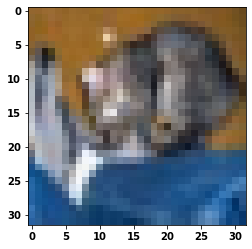

In [6]:
im = x[0].permute(1, 2, 0).numpy()
im = (im - im.min()) / (im.max() - im.min())
plt.imshow(im)

## Model

In [7]:
module = instantiate(
    configs.ImageClassificationConf(model=configs.ResNet50Conf, optim=configs.SGDConf)
)

### Test with pre-trained model

In [8]:
# Download a version from here
from pathlib import Path

Path("data").mkdir(exist_ok=True)
ckpt = Path("data") / "torchvision_cifar_l2_1_0.pt"
if not ckpt.exists():
    import requests

    headers = {"user-agent": "Wget/1.16 (linux-gnu)"}
    url = "https://www.dropbox.com/s/oagh1e6vji2z252/torchvision_cifar_l2_1_0.pt?dl=1"
    r = requests.get(url, stream=True, headers=headers)
    with open(ckpt, "wb") as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)

module.model.load_state_dict(torch.load(ckpt)["state_dict"])

<All keys matched successfully>

In [9]:
module.eval()
module(x).argmax(1) == y

tensor([True, True, True, True, True, True, True, True, True, True])

## Train

In [10]:
trainer = instantiate(
    configs.TrainerConf(
        accelerator="dp", default_root_dir="outputs/lightning", max_epochs=1
    )
)
# trainer.fit(module, datamodule=data)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


## Hydra-Run

In [11]:
from hydra_zen.experimental import hydra_run

In [16]:
def task_function(cfg):
    data = instantiate(cfg.experiment.lightning_data_module)
    model = instantiate(cfg.experiment.lightning_module)
    trainer = instantiate(cfg.experiment.lightning_trainer)
    trainer.fit(model, datamodule=data)
    return model

In [19]:
job = hydra_run(
    configs.Config,
    task_function=task_function,
    overrides=[
        "model=resnet18",
        "optim=sgd",
        "optim.lr=0.05",
        "experiment.lightning_data_module.batch_size=512",
        "experiment.lightning_trainer.accelerator=dp",
        "experiment.lightning_trainer.max_epochs=1",
    ],
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ResNet           | 11.2 M
1 | predictor | Softmax          | 0     
2 | criterion | CrossEntropyLoss | 0     
3 | metrics   | MetricCollection | 0     
-----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.696    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [20]:
job.working_dir

'outputs/2021-05-17/13-50-21'

In [21]:
trained_module = job.return_value

## Hydra-Multirun

In [22]:
from hydra_zen.experimental import hydra_multirun

In [23]:
job = hydra_multirun(
    configs.Config,
    task_function=task_function,
    overrides=[
        "model=resnet18,resnet50",
        "optim=sgd,adam",
        "experiment.lightning_trainer.max_epochs=1",
        "experiment.lightning_trainer.accelerator=dp",
    ],
)

[2021-05-17 13:50:47,245][HYDRA] Launching 4 jobs locally
[2021-05-17 13:50:47,246][HYDRA] 	#0 : model=resnet18 optim=sgd experiment.lightning_trainer.max_epochs=1 experiment.lightning_trainer.accelerator=dp
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ResNet           | 11.2 M
1 | predictor | Softmax          | 0     
2 | criterion | CrossEntropyLoss | 0     
3 | metrics   | MetricCollection | 0     
-----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.696    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[2021-05-17 13:51:10,174][HYDRA] 	#1 : model=resnet18 optim=adam experiment.lightning_trainer.max_epochs=1 experiment.lightning_trainer.accelerator=dp
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ResNet           | 11.2 M
1 | predictor | Softmax          | 0     
2 | criterion | CrossEntropyLoss | 0     
3 | metrics   | MetricCollection | 0     
-----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.696    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[2021-05-17 13:51:34,787][HYDRA] 	#2 : model=resnet50 optim=sgd experiment.lightning_trainer.max_epochs=1 experiment.lightning_trainer.accelerator=dp
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ResNet           | 23.5 M
1 | predictor | Softmax          | 0     
2 | criterion | CrossEntropyLoss | 0     
3 | metrics   | MetricCollection | 0     
-----------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.083    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[2021-05-17 13:52:38,517][HYDRA] 	#3 : model=resnet50 optim=adam experiment.lightning_trainer.max_epochs=1 experiment.lightning_trainer.accelerator=dp
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ResNet           | 23.5 M
1 | predictor | Softmax          | 0     
2 | criterion | CrossEntropyLoss | 0     
3 | metrics   | MetricCollection | 0     
-----------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.083    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [24]:
len(job[0])

4

In [25]:
job[0][0].working_dir

'multirun/2021-05-17/13-50-46/0'

In [26]:
print(to_yaml(job[0][0].cfg.model))

_target_: image_classifier.resnet.resnet18
_recursive_: true
_convert_: none



In [27]:
print(to_yaml(job[0][0].cfg.optim))

_target_: hydra_zen.funcs.partial
_recursive_: true
_convert_: none
_partial_target_:
  _target_: hydra_zen.funcs.get_obj
  path: torch.optim.sgd.SGD
lr: 0.1
momentum: 0.9



In [28]:
job[0][0].cfg.experiment.lightning_data_module.batch_size

256

In [29]:
isinstance(job[0][0].return_value, torch.nn.Module)

True